In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from collections import deque
from tqdm import tqdm  
import pandas as pd
import copy

In [2]:
P_0_matrix=np.zeros((50,50))
for i in range(50):
    temp=np.zeros((50,))
    if i==0 :
        x=np.random.exponential(size=2)
        temp[i]+=x[0]/x.sum()
        temp[i+1]+=x[1]/x.sum()
        P_0_matrix[0]=P_0_matrix[0]+temp
    elif i==49:
        x=np.random.exponential(size=2)
        temp[i-1]+=x[0]/x.sum()
        temp[i]+=x[1]/x.sum()
        P_0_matrix[49]=P_0_matrix[49]+temp
    else:
        x=np.random.exponential(size=3)
        temp[i-1]+=x[0]/x.sum()
        temp[i]+=x[1]/x.sum()
        temp[i+1]=x[2]/x.sum()
        P_0_matrix[i]=P_0_matrix[i]+temp
print(P_0_matrix)


[[0.73881685 0.26118315 0.         ... 0.         0.         0.        ]
 [0.8244554  0.08800113 0.08754346 ... 0.         0.         0.        ]
 [0.         0.22049019 0.47741673 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19795463 0.45158499 0.        ]
 [0.         0.         0.         ... 0.08417532 0.88170679 0.03411789]
 [0.         0.         0.         ... 0.         0.93402461 0.06597539]]


In [3]:
P_1_matrix=np.zeros((50,50))
for i in range(50):
    temp=np.zeros((50,))
    if i==0 :
        x=np.random.exponential(size=2)
        temp[i]+=x[0]/x.sum()
        temp[i+1]+=x[1]/x.sum()
        P_1_matrix[0]=P_1_matrix[0]+temp
    elif i==49:
        x=np.random.exponential(size=2)
        temp[i-1]+=x[0]/x.sum()
        temp[i]+=x[1]/x.sum()
        P_1_matrix[49]=P_1_matrix[49]+temp
    else:
        x=np.random.exponential(size=3)
        temp[i-1]+=x[0]/x.sum()
        temp[i]+=x[1]/x.sum()
        temp[i+1]=x[2]/x.sum()
        P_1_matrix[i]=P_1_matrix[i]+temp
print(P_1_matrix)


[[0.42490504 0.57509496 0.         ... 0.         0.         0.        ]
 [0.5285555  0.25960852 0.21183599 ... 0.         0.         0.        ]
 [0.         0.09898388 0.17406648 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.25864446 0.34423948 0.        ]
 [0.         0.         0.         ... 0.67207827 0.01613933 0.31178239]
 [0.         0.         0.         ... 0.         0.52699009 0.47300991]]


In [16]:
np.savetxt('P0.txt', P_0_matrix)
np.savetxt('P1.txt', P_1_matrix)

In [4]:
action_space=[0,1]
state_space=[i for i in range(50)]
reward_matrix=[[np.random.random(),np.random.random()] for _ in range(50)]
N=20
M=10
epsilon=1
subsidy=0
arm_indexes=[i for i in range(N)]


In [17]:
np.savetxt('reward.txt', reward_matrix)

In [5]:
def step(state,state_space,action,P_0_matrix,P_1_matrix,reward_matrix):
  new_state=state
  if(action==1):
    new_state=np.random.choice(state_space,replace=True,p=P_1_matrix[state])
    reward=reward_matrix[state][1]
  else:
    new_state=np.random.choice(state_space,replace=True,p=P_0_matrix[state])
    reward=reward_matrix[state][0]
  return [new_state,reward]

In [6]:
Q=copy.deepcopy(reward_matrix)

In [7]:


def act(Q_values,epsilon,state):
  decision=np.random.binomial(n=1,p=epsilon,size=1)
  if decision==1:
    action=random.choice([0,1])
  else:
    action=np.argmax(Q_values[state])
  return action

In [8]:
alternative_indexes=[0 for _ in range(N)]
current_state=[random.choice(state_space) for _ in range(N)]

In [9]:
rewards=[]
subsidies=[]
action_sums=[]
betas=[]
alphas=[]
epsilon=1

In [10]:
for i in range(1,2000001):
  # top_M_indices=act(alternative_indexes,N,M,epsilon)
  action_sum=0
  reward_sum=0
  alpha=1/np.ceil(1+i/1000)
  # if(i<50000):
  #   beta=0
  # else:
  if i%50==0:
    beta=1/(1+np.ceil((i)*np.log(i)/1000))
  else:
    beta=0
  for index in arm_indexes:
      # action=np.argmax(Q_values[index][current_state[index]])
      action=act(Q,epsilon,current_state[index])
      action_sum+=action
      x=step(current_state[index],state_space,action,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      if action==1:
        Q[current_state[index]][action]=(1-alpha)*(Q[current_state[index]][action])+alpha*(reward+max(Q[new_state])-(np.array(Q).sum())/100)
      else:
        Q[current_state[index]][action]=(1-alpha)*(Q[current_state[index]][action])+alpha*(reward+subsidy+max(Q[new_state])-(np.array(Q).sum())/100)
      current_state[index]=new_state
      reward_sum+=reward
      #print(x)
  # print(i)
  #print(reward_sum)

  subsidy+=beta*(action_sum-M)
  subsidies.append(subsidy)
  epsilon=epsilon*0.9999
  rewards.append(reward_sum)
  action_sums.append(action_sum)
  betas.append(beta)
  alphas.append(alpha)








Text(0.5, 1.0, 'Subsidy vs Steps for Non Indexable Example')

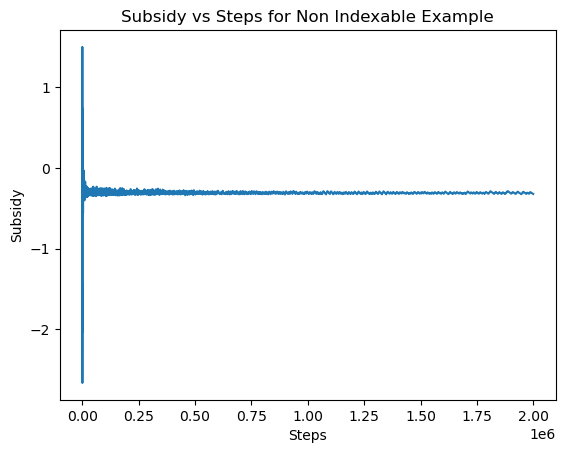

In [11]:
plt.plot(subsidies)
plt.xlabel('Steps')
plt.ylabel('Subsidy')
plt.title('Subsidy vs Steps for Non Indexable Example')

In [12]:
df=pd.DataFrame(rewards)


Text(0.5, 1.0, ' Moving Average of reward for Non Indexable Example ')

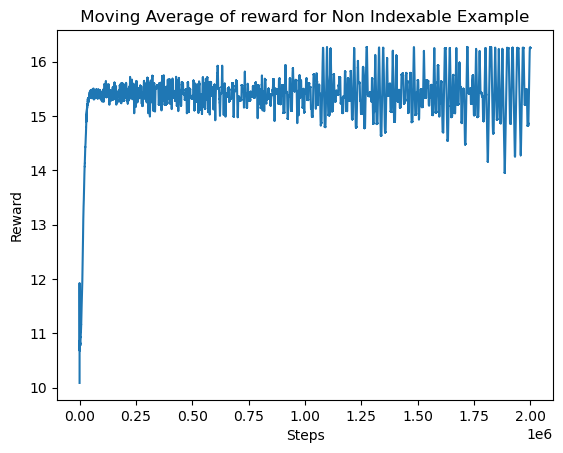

In [13]:
plt.plot(df[0].rolling(10000,min_periods=1).mean())
# plt.axhline(y = 14, color = 'r', linestyle = '-') 
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.title(' Moving Average of reward for Non Indexable Example ')


In [24]:
df['action_sums']=action_sums
plt.plot(df['action_sums'].rolling(100000,min_periods=1).mean())
plt.xlabel('Steps')
plt.ylabel('Number of Arms activated')
plt.title(' Moving Average of number of arms activated for Non Indexable Example ')


ValueError: Length of values (2000000) does not match length of index (10000)

In [28]:
#using learnt indices
current_state=[0 for _ in range(N)]
reward_sums_alt_index=[]
alternative_indexes=[0 for _ in range(N)]
for i in range(1,100001):
  reward_sum_alt_index=0
  reward_sum_whittle_index=0
  for index in arm_indexes:
    alternative_indexes[index]=Q[current_state[index]][1]-Q[current_state[index]][0]
  indices_to_pull = sorted(range(len(alternative_indexes)), key = lambda j: alternative_indexes[j])[-M:]
  for index in arm_indexes:
    if index in indices_to_pull:
      x=step(current_state[index],state_space,1,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_alt_index+=reward
    else:
      x=step(current_state[index],state_space,0,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_alt_index+=reward
  reward_sums_alt_index.append(reward_sum_alt_index)


In [26]:
actual_whittle_indexes=[-19.660060396751067,
 14.373336889124467,
 -34.33975361395317,
 -12.506083358394516,
 -4.6258266880423164,
 135.10688861988373,
 -193.98326176088273,
 -25.589238750254353,
 41.00147997898981,
 -91.10347202289229,
 -1028.431961509075,
 330.7346603695959,
 -206.47827401599747,
 95.40414204527319,
 56.97438795660443,
 54.079849354264866,
 -93.66638625626456,
 12.121306014153287,
 69.99784514969211,
 -38.60252054496673,
 -7.555488950700481,
 -34.63351512783999,
 21.72237901664558,
 19.80768846580203,
 -21.724908968164083,
 -10.517356299646696,
 -14.526882166999393,
 1.7952756009480315,
 24.017293440848142,
 -14.10693269947701,
 0.5159627543090228,
 125.86790532911785,
 -0.5214318104699007,
 7.398692880250207,
 -28.017265918772782,
 25.133988212552307,
 16.52305980183279,
 -13.323900069526388,
 -10.71714934805135,
 -20.319316668781397,
 -35.68538113186529,
 -20.061405572819258,
 -22.196582124755043,
 10.841443269136771,
 1.379661259729828,
 30.44212577447818,
 -4.491056198375303,
 -32.10092860919929,
 -8.323604110837548,
 -12.085629229952396]


In [29]:
whittle_index_arms=[0 for _ in range(N)]
current_state=[0 for _ in range(N)]
reward_sums_whittle_index=[]

for i in range(1,100001):
  reward_sum_whittle_index=0
  for index in arm_indexes:
    whittle_index_arms[index]=actual_whittle_indexes[current_state[index]]
  #print(whittle_index_arms)
  indices_to_pull = sorted(range(len(whittle_index_arms)), key = lambda j: whittle_index_arms[j])[-M:]
  # print(indices_to_pull)
  for index in arm_indexes:
    if index in indices_to_pull:
      x=step(current_state[index],state_space,1,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_whittle_index+=reward
    else:
      x=step(current_state[index],state_space,0,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_whittle_index+=reward
  reward_sums_whittle_index.append(reward_sum_whittle_index)

Text(0.5, 1.0, ' Moving Average of reward for Non Whittle Indexable Example ')

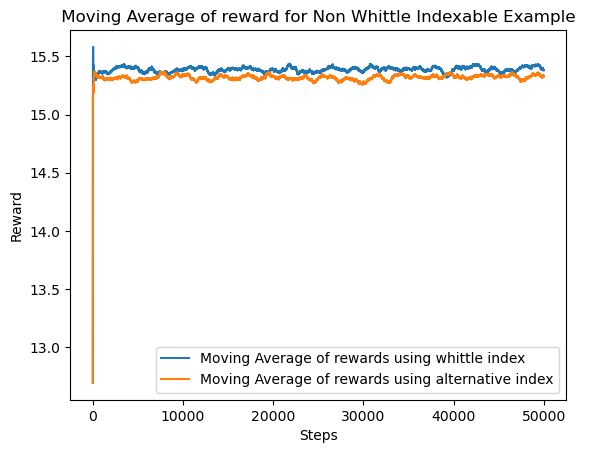

In [30]:
df=pd.DataFrame()
df['reward_whittle']=reward_sums_whittle_index
df['reward_alternate']=reward_sums_alt_index

plt.plot(df['reward_whittle'][:50000].rolling(1000,min_periods=1).mean(),label='Moving Average of rewards using whittle index')
plt.plot(df['reward_alternate'][:50000].rolling(1000,min_periods=1).mean(),label='Moving Average of rewards using alternative index')
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.legend()
plt.title(' Moving Average of reward for Non Whittle Indexable Example ')